In [31]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
import matplotlib

In [33]:
import os
import logging
import argparse
import glob
import json

import numpy as np
from matplotlib.ticker import StrMethodFormatter

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from sklearn import metrics
import tensorflow as tf
import pandas as pd
from astropy.table import Table  # for NSA
from astropy import units as u
from sklearn.metrics import confusion_matrix, roc_curve
from PIL import Image
from scipy.stats import binom
from IPython.display import display, Markdown

from shared_astro_utils import astropy_utils, matching_utils
from zoobot.estimators import make_predictions, bayesian_estimator_funcs
from zoobot.tfrecord import read_tfrecord
from zoobot.uncertainty import discrete_coverage
from zoobot.estimators import input_utils, losses
from zoobot.tfrecord import catalog_to_tfrecord
from zoobot.active_learning import metrics, simulated_metrics, acquisition_utils, check_uncertainty, simulation_timeline, run_estimator_config


In [34]:
os.chdir('/home/walml/repos/zoobot')

In [35]:
label_cols = [
    'smooth-or-featured_smooth',
    'smooth-or-featured_featured-or-disk',
    'has-spiral-arms_yes',
    'has-spiral-arms_no',
#     'spiral-winding_tight',
#     'spiral-winding_medium',
#     'spiral-winding_loose',
    'bar_strong',
    'bar_weak',
    'bar_no',
    'bulge-size_dominant',
    'bulge-size_large',
    'bulge-size_moderate',
    'bulge-size_small',
    'bulge-size_none'
]

questions = [
    'smooth-or-featured',
    'has-spiral-arms',
#     'spiral-winding',
    'bar',
    'bulge-size'
]

schema = losses.Schema(label_cols, questions, version='decals')
schema.questions

{smooth-or-featured, indices 0 to 1, asked after None: (0, 1), has-spiral-arms, indices 2 to 3, asked after <zoobot.estimators.losses.Answer object at 0x7f6c38aa5850>: (2, 3), bar, indices 4 to 6, asked after <zoobot.estimators.losses.Answer object at 0x7f6c38aa5850>: (4, 6), bulge-size, indices 7 to 11, asked after <zoobot.estimators.losses.Answer object at 0x7f6c38aa5850>: (7, 11)}


[smooth-or-featured, indices 0 to 1, asked after None,
 has-spiral-arms, indices 2 to 3, asked after <zoobot.estimators.losses.Answer object at 0x7f6c38aa5850>,
 bar, indices 4 to 6, asked after <zoobot.estimators.losses.Answer object at 0x7f6c38aa5850>,
 bulge-size, indices 7 to 11, asked after <zoobot.estimators.losses.Answer object at 0x7f6c38aa5850>]

In [36]:
# df = pd.read_csv('temp/master_256_predictions_2500init.csv')
df = pd.read_csv('temp/effnet_latest.csv')

/home/walml/anaconda3/envs/zoobot/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (109) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [37]:
df.head()

Unnamed: 0              iauname  nsa_id  ra_subject  dec_subject  \
0        3007  J114311.80-005945.4    6394  175.799176    -0.995977   
1        3013  J114234.93-010223.3    6409  175.645594    -1.039803   
2        3014  J114158.56-011334.4    6411  175.494016    -1.226278   
3        3015  J114221.35-011301.2    6414  175.588955    -1.217026   
4        3021  J114100.38-005812.6    6430  175.251666    -0.970073   

   petrotheta  petroth50  petroth90  redshift  \
0    4.769891   2.403030   5.330101  0.093060   
1    8.798181   3.986430   9.777639  0.108958   
2    9.472872   3.862174  10.472028  0.107790   
3    6.101641   2.886945   7.018666  0.076975   
4    8.128530   3.944574   9.274990  0.028913   

                                      local_fits_loc  ...  \
0  /Volumes/alpha/decals/fits_native/dr5/J114/J11...  ...   
1  /Volumes/alpha/decals/fits_native/dr5/J114/J11...  ...   
2  /Volumes/alpha/decals/fits_native/dr5/J114/J11...  ...   
3  /Volumes/alpha/decals/fits_native/dr5/J114/J11...  ...   
4  /Volumes/alpha/decals/fits_native/dr5/J114/J11...  ...   

                      bulge-size_dominant_prediction  \
0  [0.04262910038232803, 0.016658904030919075, 0....   
1  [0.007415104657411575, 0.007838904857635498, 0...   
2  [0.008610561490058899, 0.0071463510394096375, ...   
3  [0.021249478682875633, 0.018415333703160286, 0...   
4  [0.00965325441211462, 0.017385421320796013, 0....   

   bulge-size_dominant_prediction_mean  \
0                             0.023788   
1                             0.006908   
2                             0.008307   
3                             0.019684   
4                             0.012718   

                         bulge-size_large_prediction  \
0  [0.15324892103672028, 0.08992495387792587, 0.1...   
1  [0.03921530023217201, 0.04610105976462364, 0.0...   
2  [0.0454450361430645, 0.04326174035668373, 0.05...   
3  [0.10940727591514587, 0.1085921972990036, 0.10...   
4  [0.03677285462617874, 0.0501408725976944, 0.04...   

   bulge-size_large_prediction_mean  \
0                          0.119022   
1                          0.044864   
2                          0.041897   
3                          0.106024   
4                          0.050768   

                      bulge-size_moderate_prediction  \
0  [0.19541844725608826, 0.2901086211204529, 0.29...   
1  [0.41776421666145325, 0.4635247588157654, 0.49...   
2  [0.4529438018798828, 0.46400731801986694, 0.35...   
3  [0.5854149460792542, 0.5571314096450806, 0.584...   
4  [0.3044124245643616, 0.17468252778053284, 0.31...   

   bulge-size_moderate_prediction_mean  \
0                             0.247091   
1                             0.492537   
2                             0.428557   
3                             0.566463   
4                             0.263830   

                         bulge-size_small_prediction  \
0  [0.20418624579906464, 0.3926066756248474, 0.25...   
1  [0.5211817622184753, 0.4722156524658203, 0.435...   
2  [0.4478592872619629, 0.44699808955192566, 0.46...   
3  [0.23216891288757324, 0.27923446893692017, 0.2...   
4  [0.4528931975364685, 0.24049556255340576, 0.41...   

   bulge-size_small_prediction_mean  \
0                          0.302042   
1                          0.444397   
2                          0.484512   
3                          0.250000   
4                          0.330399   

                          bulge-size_none_prediction  \
0  [0.4045172929763794, 0.2107008546590805, 0.263...   
1  [0.014423578977584839, 0.010319691151380539, 0...   
2  [0.045141324400901794, 0.03858647122979164, 0....   
3  [0.05175939202308655, 0.03662663325667381, 0.0...   
4  [0.19626830518245697, 0.5172955989837646, 0.20...   

   bulge-size_none_prediction_mean  
0                         0.308057  
1                         0.011294  
2                         0.036727  
3                         0.057829  
4                         0.342286  

[5 rows x 135 columns]

In [38]:
smooth_samples = np.array([json.loads(x) for x in df['smooth-or-featured_smooth_prediction']])
smooth_samples

array([[0.1628457 , 0.12317292, 0.15922555, ..., 0.15382065, 0.17402089,
        0.21653813],
       [0.06466458, 0.06834858, 0.06288904, ..., 0.05078624, 0.06817643,
        0.0443319 ],
       [0.15726911, 0.15653938, 0.27009985, ..., 0.16222149, 0.21568276,
        0.16886522],
       ...,
       [0.07390058, 0.05374718, 0.04901228, ..., 0.05525795, 0.05563412,
        0.08546674],
       [0.19347607, 0.16450958, 0.23118557, ..., 0.19199516, 0.21741597,
        0.19941314],
       [0.34397814, 0.39627868, 0.33753961, ..., 0.41243997, 0.36733332,
        0.36609507]])

In [39]:
smooth_acq = acquisition_utils.mutual_info_acquisition_func(smooth_samples, 40)

(array([2.360e+03, 3.343e+03, 2.488e+03, 1.395e+03, 6.610e+02, 2.670e+02,
        7.800e+01, 2.200e+01, 8.000e+00, 2.000e+00]),
 array([0.00339099, 0.06324805, 0.12310511, 0.18296217, 0.24281922,
        0.30267628, 0.36253334, 0.4223904 , 0.48224745, 0.54210451,
        0.60196157]),
 <a list of 10 Patch objects>)

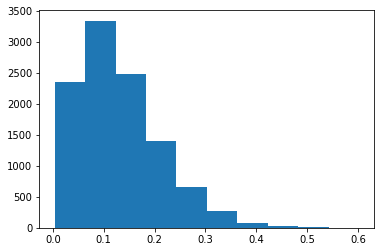

In [40]:
plt.hist(smooth_acq)

In [41]:
df['file_loc'][np.argsort(smooth_acq)[-10:]]

2199    /media/walml/beta/decals/png_native/dr5/J004/J...
3165    /media/walml/beta/decals/png_native/dr5/J015/J...
3433    /media/walml/beta/decals/png_native/dr5/J022/J...
342     /media/walml/beta/decals/png_native/dr5/J132/J...
5785    /media/walml/beta/decals/png_native/dr5/J141/J...
4273    /media/walml/beta/decals/png_native/dr5/J090/J...
1914    /media/walml/beta/decals/png_native/dr5/J002/J...
2344    /media/walml/beta/decals/png_native/dr5/J005/J...
2396    /media/walml/beta/decals/png_native/dr5/J005/J...
8177    /media/walml/beta/decals/png_native/dr5/J011/J...
Name: file_loc, dtype: object

In [42]:
# copied from trust_the_model.ipynb
def show_galaxies(df, scale=3, nrows=3, ncols=3):
    fig = plt.gcf()

    plt.figure(figsize=(scale * nrows, scale * ncols * 1.025))
    gs1 = gridspec.GridSpec(nrows, ncols)
    gs1.update(wspace=0.0, hspace=0.0)
    galaxy_n = 0
    for row_n in range(nrows):
        for col_n in range(ncols):
            galaxy = df.iloc[galaxy_n]
            image = Image.open(galaxy['file_loc'])
            ax = plt.subplot(gs1[row_n, col_n])
            ax.imshow(image)
#             ax.text(10, 20, 'Smooth = {:.2f}'.format(galaxy['smooth-or-featured_smooth_fraction']), fontsize=12, color='r')
#             ax.text(10, 50, r'$\rho = {:.2f}$, Var ${:.3f}$'.format(galaxy['median_prediction'], 3*galaxy['predictions_var']), fontsize=12, color='r')
#             ax.text(10, 80, '$L = {:.2f}$'.format(galaxy['bcnn_likelihood']), fontsize=12, color='r')
            ax.axis('off')
            galaxy_n += 1
#     print('Mean L: {:.2f}'.format(df[:nrows * ncols]['bcnn_likelihood'].mean()))
    fig = plt.gcf()
#     fig.tight_layout()
    return fig


<Figure size 432x288 with 0 Axes>

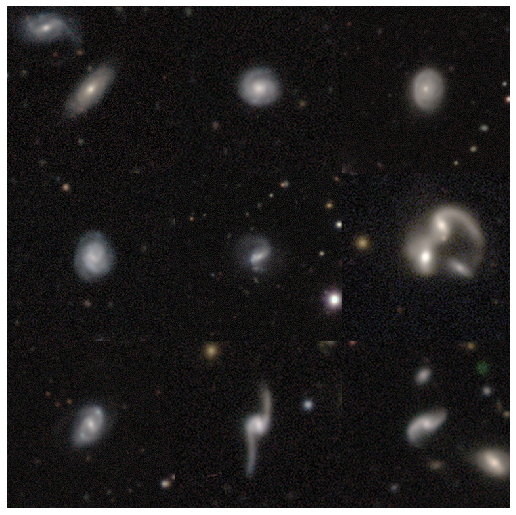

In [43]:
top_smooth = df.iloc[np.argsort(smooth_acq)[-10:]]
_ = show_galaxies(top_smooth)

<Figure size 432x288 with 0 Axes>

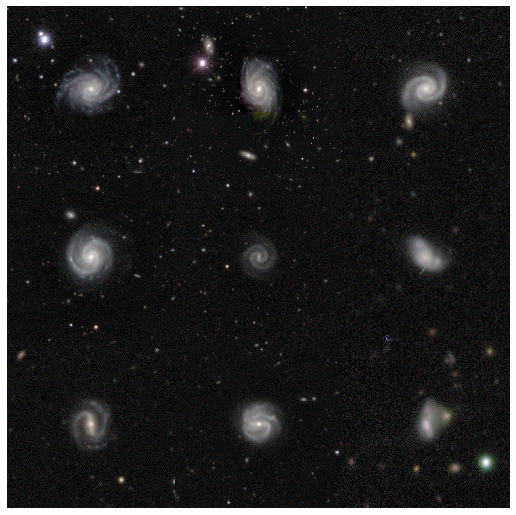

In [44]:
bottom_smooth = df.iloc[np.argsort(smooth_acq)[:10]]
_ = show_galaxies(bottom_smooth)

In [61]:
df.columns.values

array(['Unnamed: 0', 'iauname', 'nsa_id', 'ra_subject', 'dec_subject',
       'petrotheta', 'petroth50', 'petroth90', 'redshift',
       'local_fits_loc', 'local_png_loc', 'fits_ready', 'fits_filled',
       'png_ready', 'best_match', 'sky_separation', 'nsa_version', 'mag',
       'ra', 'dec', 'file_loc', 'subject_id', 'bar_no', 'bar_strong',
       'bar_weak', 'bulge-size_dominant', 'bulge-size_large',
       'bulge-size_moderate', 'bulge-size_none', 'bulge-size_small',
       'disk-edge-on_no', 'disk-edge-on_yes', 'edge-on-bulge_boxy',
       'edge-on-bulge_none', 'edge-on-bulge_rounded',
       'has-spiral-arms_no', 'has-spiral-arms_yes',
       'how-rounded_cigar-shaped', 'how-rounded_in-between',
       'how-rounded_round', 'merging_both-v1',
       'merging_major-disturbance', 'merging_merger',
       'merging_minor-disturbance', 'merging_neither-v1', 'merging_none',
       'merging_tidal-debris-v1', 'smooth-or-featured_artifact',
       'smooth-or-featured_featured-or-disk', 'sm

In [62]:
spiral_samples = np.array([json.loads(x) for x in df['has-spiral-arms_yes_prediction']])
spiral_acq = acquisition_utils.mutual_info_acquisition_func(spiral_samples, df['smooth-or-featured_featured-or-disk'])


<Figure size 432x288 with 0 Axes>

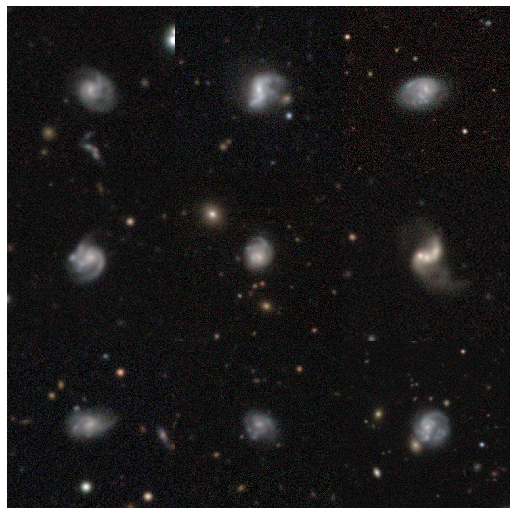

In [64]:
top_spiral = df.iloc[np.argsort(spiral_acq)[-10:]]
_ = show_galaxies(top_spiral)

<Figure size 432x288 with 0 Axes>

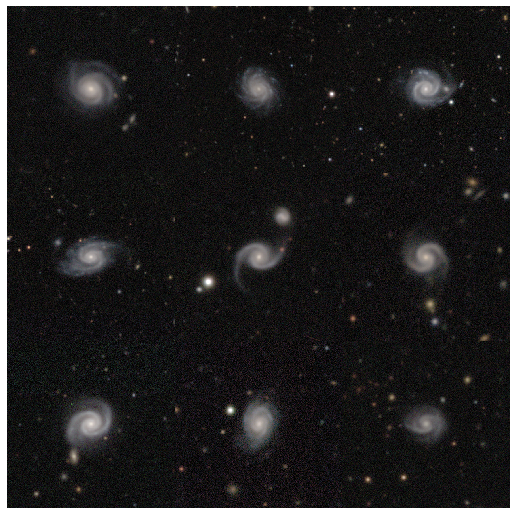

In [65]:
bottom_spiral = df.iloc[np.argsort(spiral_acq)[:10]]
_ = show_galaxies(bottom_spiral)

In [45]:
samples = np.array([np.array([json.loads(x) for x in df[answer + '_prediction']]) for answer in label_cols]).swapaxes(0, 1)
samples.shape

(10624, 12, 15)

In [46]:
acquisition_values = acquisition_utils.mutual_info_acquisition_func_multiq(samples, schema, retirement=40)
acquisition_values.shape

(10624, 12)

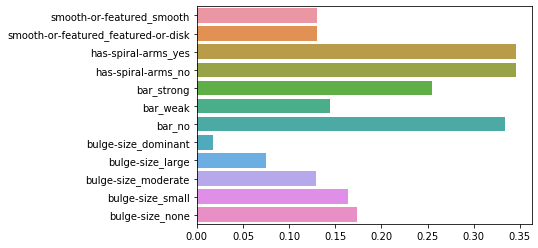

In [47]:
sns.barplot(x=acquisition_values.mean(axis=0), y=label_cols)

In [48]:
acq_by_answer = acquisition_values.mean(axis=0)
acq_by_q = {}
for q, indices in schema.named_index_groups.items():  # yay for ordered dicts
    acq_by_q[q.text] = acq_by_answer[indices[0]:indices[1]+1].mean()

In [49]:
acq_by_q

{'smooth-or-featured': 0.13009875107006735,
 'has-spiral-arms': 0.3455182985346579,
 'bar': 0.24449945634682457,
 'bulge-size': 0.11208921997876109}

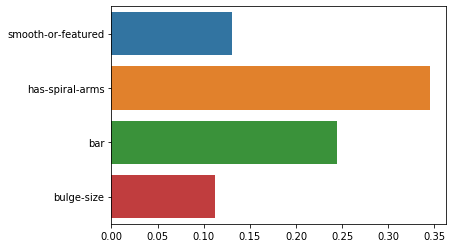

In [50]:
sns.barplot(x=[v for v in acq_by_q.values()], y=[k for k in acq_by_q.keys()])

In [51]:
schema.named_index_groups

{smooth-or-featured, indices 0 to 1, asked after None: (0, 1),
 has-spiral-arms, indices 2 to 3, asked after <zoobot.estimators.losses.Answer object at 0x7f6c38aa5850>: (2,
  3),
 bar, indices 4 to 6, asked after <zoobot.estimators.losses.Answer object at 0x7f6c38aa5850>: (4,
  6),
 bulge-size, indices 7 to 11, asked after <zoobot.estimators.losses.Answer object at 0x7f6c38aa5850>: (7,
  11)}

In [52]:
temp = pd.DataFrame(data=[x for x in acquisition_values], columns=label_cols)

In [53]:
temp.head()

smooth-or-featured_smooth  smooth-or-featured_featured-or-disk  \
0                   0.203726                             0.203726   
1                   0.052311                             0.052311   
2                   0.126090                             0.126090   
3                   0.025507                             0.025507   
4                   0.046019                             0.046019   

   has-spiral-arms_yes  has-spiral-arms_no  bar_strong  bar_weak    bar_no  \
0             0.534254            0.534254    0.242176  0.153652  0.332961   
1             0.171322            0.171322    0.279888  0.215044  0.431601   
2             0.100965            0.100965    0.193805  0.074474  0.203683   
3             0.117972            0.117972    0.284429  0.080019  0.312680   
4             0.639714            0.639714    0.316202  0.359775  0.581338   

   bulge-size_dominant  bulge-size_large  bulge-size_moderate  \
0             0.046829          0.250741             0.207251   
1             0.002183          0.013852             0.121353   
2             0.007910          0.048889             0.117548   
3             0.005467          0.031809             0.033409   
4             0.009303          0.035901             0.218647   

   bulge-size_small  bulge-size_none  
0          0.332118         0.559945  
1          0.139252         0.012958  
2          0.098120         0.170725  
3          0.031264         0.040918  
4          0.183791         0.481336

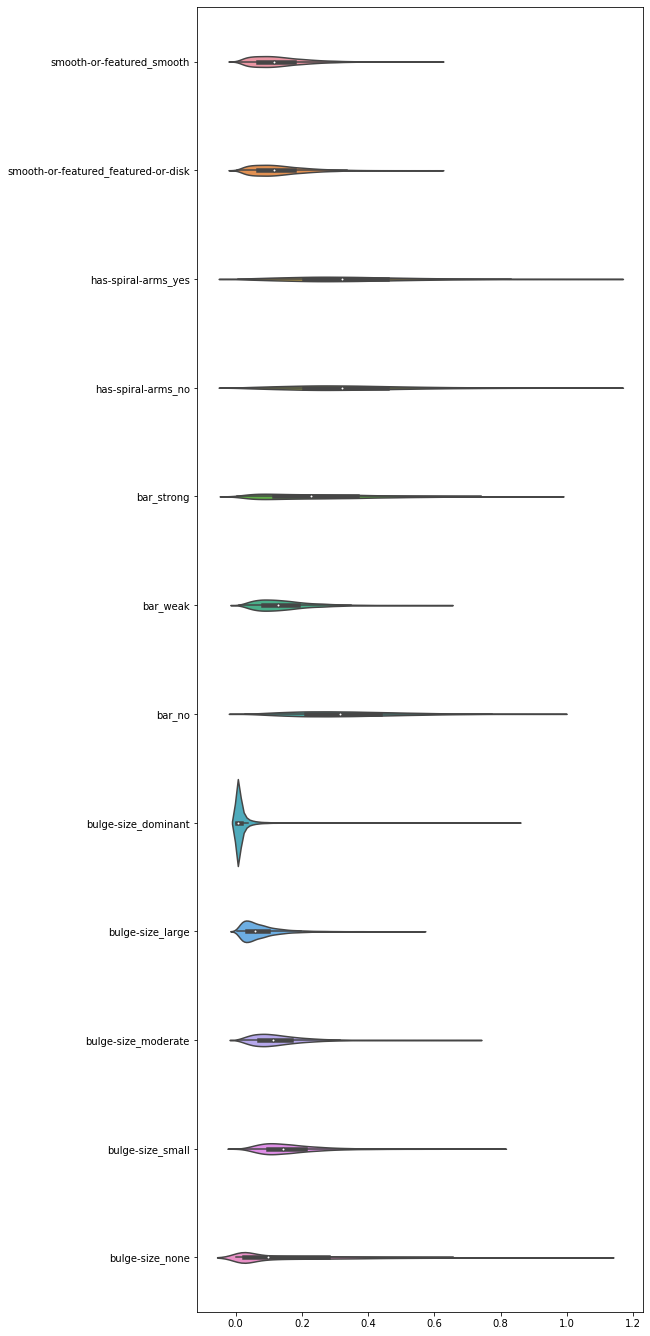

In [54]:
fig, ax = plt.subplots(figsize=(8, 24))
sns.violinplot(data=temp, orient='h', ax=ax)

In [55]:
ordered_by_acq = df.iloc[np.argsort(acquisition_values.mean(axis=1))]

<Figure size 432x288 with 0 Axes>

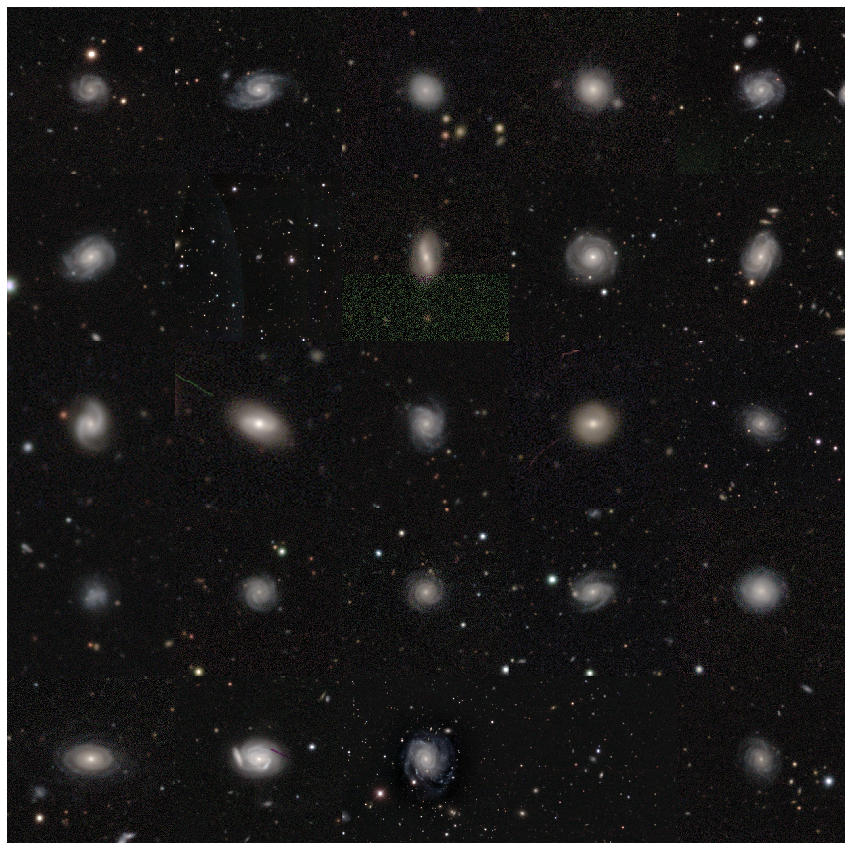

In [56]:
_ = show_galaxies(ordered_by_acq[:25], ncols=5, nrows=5)

<Figure size 432x288 with 0 Axes>

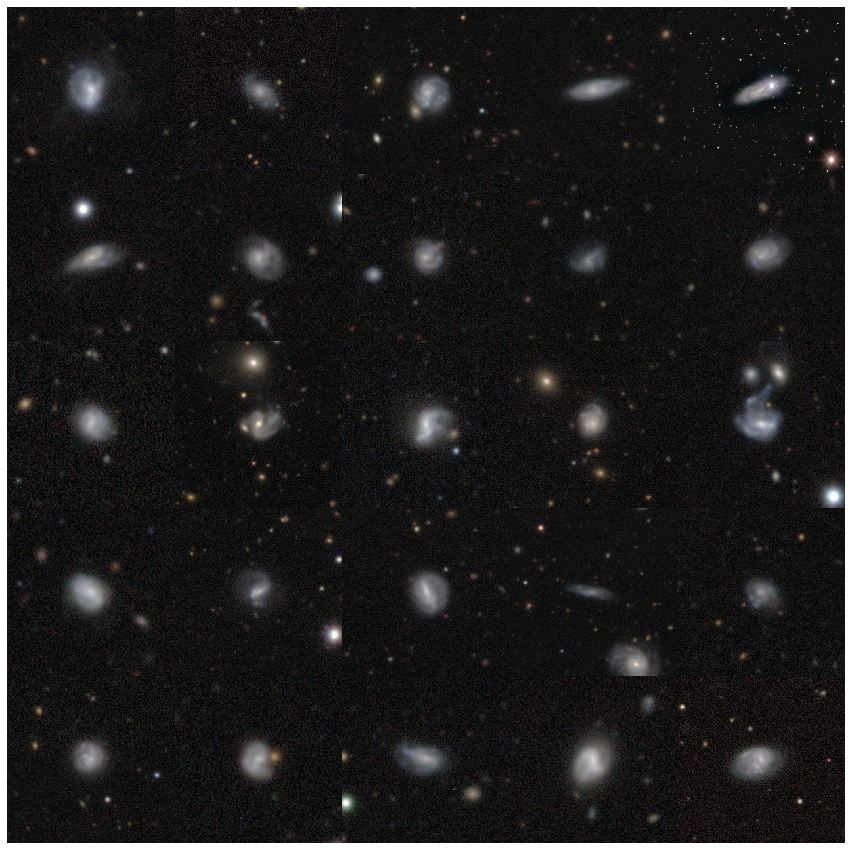

In [57]:
_ = show_galaxies(ordered_by_acq[-25:], ncols=5, nrows=5)

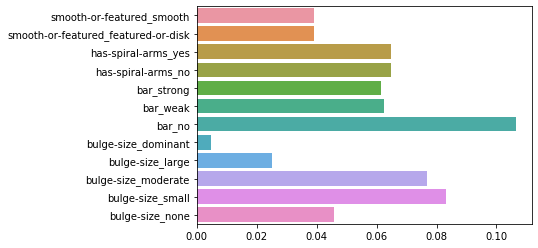

In [58]:
acq_sorted = acquisition_values[np.argsort(acquisition_values.mean(axis=1))]
sns.barplot(x=acq_sorted[:100].mean(axis=0), y=label_cols)

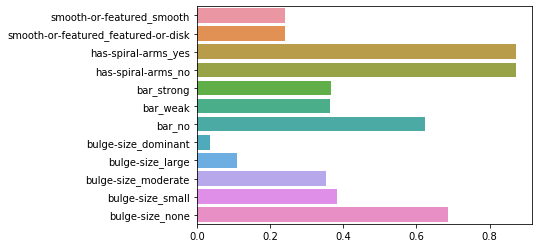

In [59]:
sns.barplot(x=acq_sorted[-100:].mean(axis=0), y=label_cols)

In [ ]:
TODO show galaxies ordered by uncertainty